In [1]:
import os
import numpy as np
from scipy.stats import pearsonr
import pandas as pd
import coolbox
from coolbox.api import *

# plotting modules
import seaborn as sns
from matplotlib.ticker import MultipleLocator
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.sans-serif'] = "Arial" # missing fonts:: https://alexanderlabwhoi.github.io/post/2021-03-missingfont/
# Then, "ALWAYS use sans-serif fonts"
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams.update({'font.size': 14, 'axes.linewidth': 2, 'xtick.major.width': 1.5, 'xtick.major.size': 5, 'ytick.major.width': 1.5, 'ytick.major.size': 4})
from matplotlib.backends.backend_pdf import PdfPages

/data5/deepro/miniconda3/envs/starrseq/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def save_pdf(save_file, fig):
    pdf = PdfPages(save_file)
    pdf.savefig(fig, bbox_inches='tight', dpi=300)
    pdf.close()
    return

In [3]:
meta_activity_map_file = "../data/meta_activity_map.csv"
save_dir = "../data/figures/activity_map"
libraries = ["CC", "ATF2", "CTCF", "FOXA1", "LEF1", "SCRT1", "TCF7L2", "16P12_1"]

In [4]:
meta_df = pd.read_csv(meta_activity_map_file)

In [5]:
def merge_multi_fragment_into_one(merge_df, libraries):
    # merge overlapping locations
    # sort the dataframe by chromosomal coordinates
    merge_df_locations = merge_df.chrom_coord.str.split("_", expand=True)
    merge_df_locations.columns = ["chr", "start", "end"]
    merge_df_locations = merge_df_locations.astype({'start': 'int32', 'end': 'int32'})
    merge_df = merge_df.merge(merge_df_locations, left_index=True, right_index=True)
    merge_df = merge_df.sort_values(["chr", "start", "end"])

    def activity_function(x):
        x = list(x)
        return x[np.argmax(np.abs(x))]

    dict_function = {
        "index": lambda x: list(x)[0],
        "chrom_coord": lambda x: list(x)[0],
        "variability": max,
    }

    for lib in libraries:
        dict_function[lib] = activity_function
        if lib!="CC":
            dict_function[f"{lib}_padj"] = min
            dict_function[f"{lib}_log2FoldChange"] = activity_function

    grouped_dfs = []
    for group, df in merge_df.groupby("chr"): # https://stackoverflow.com/questions/46732760/merge-rows-pandas-dataframe-based-on-condition
        grouped_df = df.groupby(((df.start  - df.end.shift(1)) > 0).cumsum()).agg(dict_function)
        grouped_df["chr"] = group
        grouped_dfs.append(grouped_df)

    merged_df = pd.concat(grouped_dfs)
    return merged_df.drop(columns="chr").reset_index(drop=True)

In [6]:
meta_df["variability"] = meta_df.loc[:, libraries].std(axis=1)
variable_df = meta_df.sort_values("variability", ascending=False).reset_index(drop=False)
variable_df = variable_df.loc[variable_df.variability>1.25]

In [7]:
variable_df = merge_multi_fragment_into_one(variable_df, libraries)

In [8]:
activity_df = variable_df.melt(id_vars=["index"], value_vars=libraries[1:], var_name="Libraries", value_name="activity")
diff_activity_df = variable_df.melt(id_vars=["index"], value_vars=[f"{l}_padj" for l in libraries[1:]], var_name="Libraries", value_name="diff_activity")
diff_activity_df["Libraries"] = diff_activity_df.Libraries.str.rstrip("_padj")
plot_df = activity_df.merge(diff_activity_df, left_on = ["index", "Libraries"], right_on=["index", "Libraries"])
plot_df["diff_activity_style"] = "not significant"
plot_df.loc[plot_df.diff_activity<0.05, "diff_activity_style"] = "significant"
plot_df = plot_df.set_index("index")

In [9]:
plot_df.loc[249148].activity.max()

4.405851191752888

In [16]:
def plot_diff_activity_map(meta_df, plot_df, libraries, region_idx, legend=True):
    fig, axes = plt.subplots(1, 1, figsize=(12, 8))
    sns.lineplot(data=meta_df, x=meta_df.index, y="CC", ax=axes, linewidth=3, alpha=0.5, color="#1e61a5")

    plot_df = plot_df.loc[plot_df.Libraries.isin(libraries)]

    pnts = np.linspace(0, np.pi * 2, 24)
    circ = np.c_[np.sin(pnts) / 2, -np.cos(pnts) / 2]
    vert = np.r_[circ, circ[::-1] * .7]
    open_circle = matplotlib.path.Path(vert)

    sns.scatterplot(    
        data=plot_df, x=plot_df.index, y="activity", ax=axes, 
        hue="Libraries", hue_order=libraries,
        palette=["#fcbe07", "tan", "darkblue", "darkred", "green", "black"], # sns.color_palette("Dark2", len(libraries)), #
        marker="o", ec='none', linewidth=0.5, facecolor=(0,0,0,0), #open_circle
        # style="diff_activity_style", style_order=["not significant", "significant"], markers={"not significant": ".", "significant": "."},
        size="diff_activity_style", sizes={"not significant": 100, "significant": 100}, alpha=0.75,
        legend=legend, rasterized=True)

    if region_idx:
        for ridx in region_idx:
            loc = meta_df.loc[ridx].chrom_coord
            chrm, start, end = loc.split("_")
            act = plot_df.loc[ridx].activity.max()
            axes.annotate(f"{chrm}:{start}-{end}", xy=(ridx, act), xytext=(ridx, 6.5), arrowprops=dict(arrowstyle="->"), fontsize=10, ha="right")
            high_val =  plot_df.loc[ridx].activity.max()
            low_val = plot_df.loc[ridx].activity.min()
            axes.vlines([ridx], ymin=[low_val], ymax=[high_val], alpha=0.8, color="grey", linestyle="--", linewidth=1.5)
            # axes.text(ridx, act + np.sign(act)*0.25, f"{chrm}:{start}-{end}", fontsize=12, rotation=90, ha="center")

    # no x tick labels
    axes.set_xlabel("")
    axes.set_xticks([])
    axes.set_xticklabels([])
    # y label ticks needed
    axes.yaxis.set_tick_params(width=2, length=5, which="major")
    axes.yaxis.get_label().set_visible(False)
    axes.yaxis.set_major_locator(MultipleLocator(2))
    # draw a line at 
    axes.axhline(0, color ='black', lw = 2, alpha = 1)
    # remove spines
    axes.spines[["right", "top", "bottom"]].set_visible(False)
    if legend:
        axes.legend(markerscale=1.5, frameon=False, ncol=3, loc="lower right")
    return fig, axes

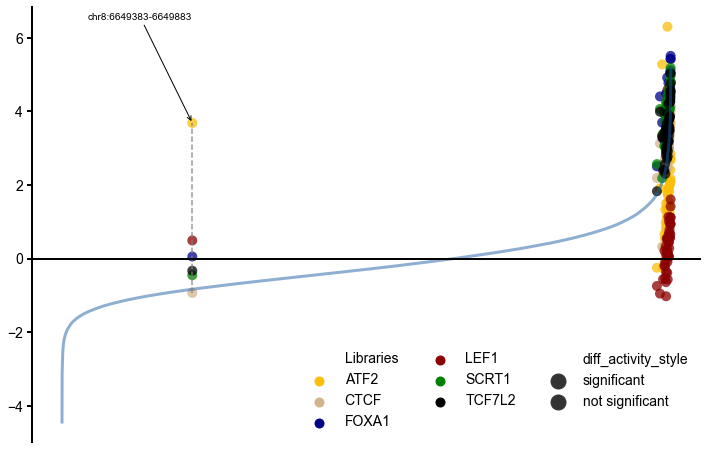

In [17]:
fig, _ = plot_diff_activity_map(meta_df, plot_df, libraries[1:-1], region_idx=[54278],)
save_file = f"../data/figures/activity_map/diff_activity.pdf"
save_pdf(save_file, fig)

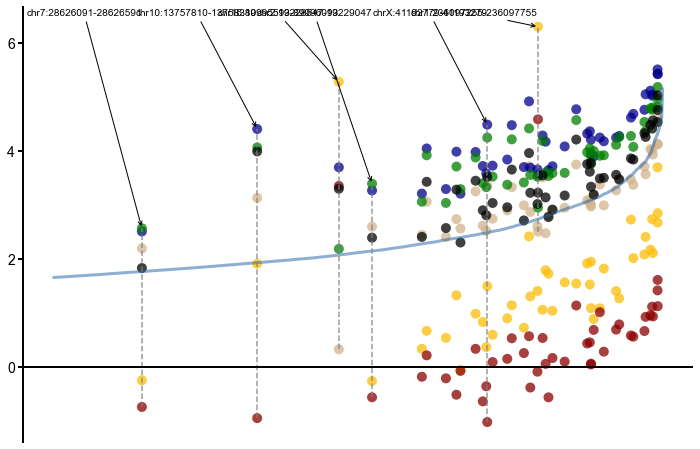

In [18]:
fig, _ = plot_diff_activity_map(meta_df.iloc[246900:], plot_df.loc[(plot_df.index>246900)], libraries[1:-1], region_idx=[247873, 249148, 250051, 250418, 251692, 252253], legend=False)
save_file = f"../data/figures/activity_map/diff_activity_zoomed.pdf"
save_pdf(save_file, fig)

In [11]:
starr_in = "/data5/deepro/starrseq/papers/reproducibility/2_dedup_align_filter/data/in_house/filtered/IN/Input_SeqReady_A1_R1_S1.bw"
starr_cc = "/data5/deepro/starrseq/papers/reproducibility/2_dedup_align_filter/data/in_house/filtered/CC/CC_R1_STARR_Seq_S4.bw"
starr_atf2 = "/data5/deepro/starrseq/papers/reproducibility/2_dedup_align_filter/data/in_house/filtered/ATF2/ATF2_R1_STARR_Seq_S10.bw"
starr_ctcf = "/data5/deepro/starrseq/papers/reproducibility/2_dedup_align_filter/data/in_house/filtered/CTCF/CTCF_R1_STARR_Seq_S13.bw"
starr_foxa1 = "/data5/deepro/starrseq/papers/reproducibility/2_dedup_align_filter/data/in_house/filtered/FOXA1/FOXA1_R1_STARR_Seq_S7.bw"
starr_lef1 = "/data5/deepro/starrseq/papers/reproducibility/2_dedup_align_filter/data/in_house/filtered/LEF1/LEF1_R1_STARR_Seq_S19.bw"
starr_scrt1 = "/data5/deepro/starrseq/papers/reproducibility/2_dedup_align_filter/data/in_house/filtered/SCRT1/SCRT1_R1_STARR_Seq_S16.bw"
starr_tcf7l2 = "/data5/deepro/starrseq/papers/reproducibility/2_dedup_align_filter/data/in_house/filtered/TCF7L2/TCF7L2_R1_STARR_Seq_S22.bw"

In [26]:
regions= ["chr17:80693000-80695800"]

# highlights = HighLights(regions, color="grey", alpha=0.1)

# with highlights:
frame = \
    BigWig(starr_tcf7l2, alpha=0.6) + Color("#ff9c9c") + \
    BigWigCoverage(starr_tcf7l2, alpha=0.6, color="purple") + \
    Title("TCF7L2") + Spacer(0.01) + \
    BigWig(starr_scrt1, alpha=0.6) + Color("#ff9c9c") + \
    BigWigCoverage(starr_scrt1, alpha=0.6, color="green") + \
    Title("SCRT1") + \
    Spacer(0.01) + \
    BigWig(starr_lef1, alpha=0.6) + Color("#ff9c9c") + \
    BigWigCoverage(starr_lef1, alpha=0.6, color="darkred") + \
    Title("LEF1") + \
    Spacer(0.01) + \
    BigWig(starr_foxa1, alpha=0.6) + Color("#ff9c9c") + \
    BigWigCoverage(starr_foxa1, alpha=0.6, color="darkblue") + \
    Title("FOXA1") + \
    Spacer(0.01) + \
    BigWig(starr_ctcf, alpha=0.6) + Color("#ff9c9c") + \
    BigWigCoverage(starr_ctcf, alpha=0.6, color="tan") + \
    Title("CTCF") + \
    Spacer(0.01) + \
    BigWig(starr_atf2, alpha=0.6) + Color("#ff9c9c") + \
    BigWigCoverage(starr_atf2, alpha=0.6, color="#fcbe07") + \
    Title("ATF2") + \
    Spacer(0.01) + \
    BigWig(starr_cc, alpha=0.6) + Color("#ff9c9c") + \
    BigWigCoverage(starr_cc, alpha=0.6, color="#66ccff") + \
    Title("CC") + \
    Spacer(0.01) + \
    BigWig(starr_in, alpha=0.6) + Color("#ff9c9c") + \
    BigWigCoverage(starr_in, alpha=0.6, color="grey") + \
    Title("IN")

# ["darkred", "dimgrey", "navy", "mediumorchid", "tan", "black"]
# ["#fcbe07", "tan", "darkblue", "darkred", "green", "purple"]
frame *= MaxValue(4200)
frame *= MinValue(0)
frame * TrackHeight(1.25)
frame = XAxis() + frame
fig = frame.plot("chr17:80675000-80700000") # chr17_78791799_78792299 to chr17_80694154_80694654 # 80796000

In [27]:
save_file = "../data/figures/variable_activity.pdf"
save_pdf(save_file, fig)